In [1]:
from utils import *
import numpy as np
import pickle as pkl
from tqdm import tqdm
import pandas as pd
import random
import matplotlib.pyplot as plt
from models import AD1
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, MinMaxScaler


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2025-07-17 15:57:27.336735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# pip install corner

In [3]:
import umap

In [4]:
colors ={'u':"#00c2f2",
         'g':"#59b359",
         'r':"#e51f00",
         'i':"#502db3",
         'z':"#ffaa00",
         'y':"#f2b6de"
        }

classes = ['uLens-Single',
           'uLens-Binary']

In [5]:
# read the first 20 data points of the lightcurves in each of gri bands

data, label = read_data(n_points = 10)

2it [00:07,  3.51s/it]


In [6]:
#split into train and test sets

random.seed(10)
data_size = len(label)
shuffler = np.random.permutation(len(label))
data = np.asarray(data)[shuffler]
train_fract = 0.9
train_size = int(train_fract*data_size)
train_set = data[:train_size]
train_label = np.asarray(label)[:train_size]

test_set = data[train_size:]
test_label = np.asarray(label)[train_size:]

In [7]:
# Read an example light curve

class_ind = 0
ind = 8

f = train_set[train_label == class_ind][ind]

Text(0, 0.5, 'Flux')

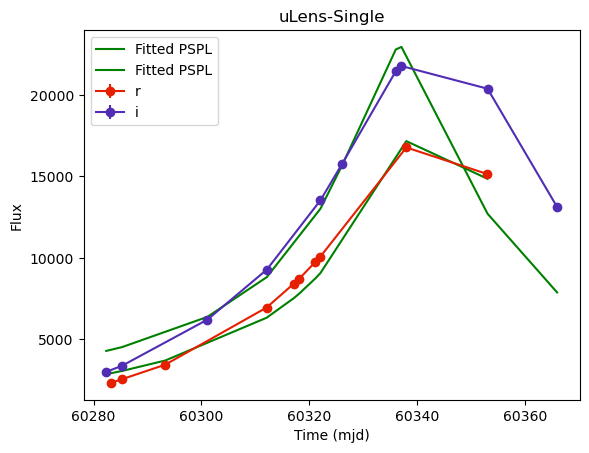

In [8]:
for b, band in enumerate(['r', 'i']):
    
    params_fit, fun_ = fit_PSPL(f[:,3*b], f[:,3*b+1], merr=f[:,3*b+2])
    

    plt.errorbar(f[:,3*b],
                 f[:,3*b+1],
                 yerr = f[:,3*b+2],
                 fmt = 'o-',
                 color = colors[band],
                 label = band)
    plt.plot(f[:,3*b], fun(f[:,3*b], *list(params_fit['x'])), 'g-', label = 'Fitted PSPL')

    
plt.legend()
plt.title(classes[class_ind])
plt.xlabel('Time (mjd)')
plt.ylabel('Flux')

In [9]:
all_params = {}
degree = 50
for d, dat in tqdm(enumerate(data)):
    all_params[d]={}
    for b, band in enumerate(['r', 'i']):
        cheby_all = fit_Cheby(dat[:, 3*b], dat[:, 3*b+1], degree=degree)
        all_params[d][band] = cheby_all

7332it [00:57, 127.86it/s]


In [10]:
chebyshev_cs_r = [all_params[i]['r']['all_coeffs'] for i in list(all_params.keys())]
chebyshev_cs_i = [all_params[i]['i']['all_coeffs'] for i in list(all_params.keys())]

In [11]:
scaler = MinMaxScaler()
cheby_binaries_scaled_r = scaler.fit_transform(chebyshev_cs_r)
cheby_binaries_scaled_i = scaler.fit_transform(chebyshev_cs_i)

In [12]:
reducer = umap.UMAP(output_metric='hyperboloid', random_state=42)
reducer.fit(cheby_binaries_scaled_r)
reducer2 = umap.UMAP(output_metric='hyperboloid', random_state=42)
reducer2.fit(cheby_binaries_scaled_i)

AttributeError: module 'umap' has no attribute 'UMAP'

Type:        module
String form: <module 'umap' (namespace)>
Docstring:   <no docstring>

In [29]:
def get_column_from_dict(all_params, col_name, band):
    tmp = []
    for i, key in enumerate(list(all_params.keys())):
        tmp.append(all_params[key][band][col_name])
    return np.asarray(tmp)

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not {'u': '#00c2f2', 'g': '#59b359', 'r': '#e51f00', 'i': '#502db3', 'z': '#ffaa00', 'y': '#f2b6de'}

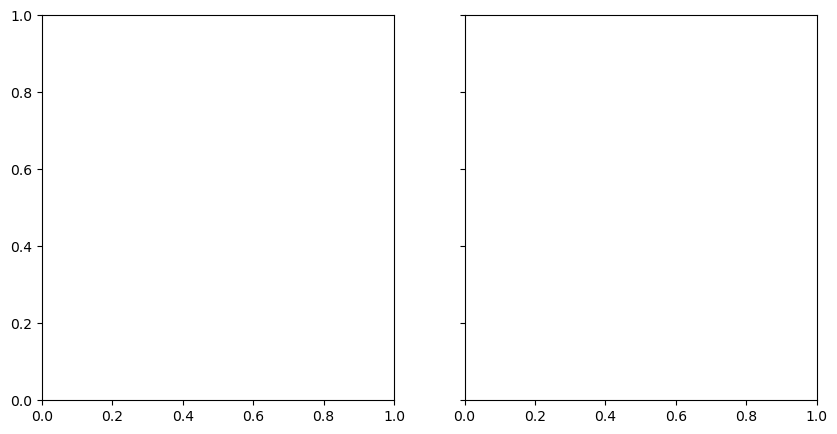

In [30]:
col1 = 'pos_log10_Cheby_cj_sqr_minus_one'
col2 = 'Cheby_a2'
col3 = 'Cheby_a4'
col4 = 'Cheby_a6'
col5 = 'Cheby_a8'
col6 = 'Cheby_a10'
col7 = 'delta_A_chebyshev_sqr'

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
for b, band in enumerate(['r', 'i']):
    x1 = get_column_from_dict(all_params, col1, band)
    x2 = get_column_from_dict(all_params, col2, band)
    x3 = get_column_from_dict(all_params, col3, band)
    x4 = get_column_from_dict(all_params, col4, band)
    x5 = get_column_from_dict(all_params, col5, band)
    x6 = get_column_from_dict(all_params, col6, band)
    x7 = get_column_from_dict(all_params, col7, band)

    colormap = ListedColormap(['red', 'green', 'blue'])
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=np.min(label), 
                vmax=np.max(label))
    
    ax[b].scatter(x1, x2, c=colors, alpha=0.1)
    ax[b].set_xlabel(col1)
    
colors = colormap(label)
plt.colorbar(sm)
ax[0].set_ylabel(col2)
ax[0].set_ylim(-1,1)

# plt.yscale('log')
# plt.xscale('log')



In [11]:
len(select_feat[label==0])

NameError: name 'select_feat' is not defined

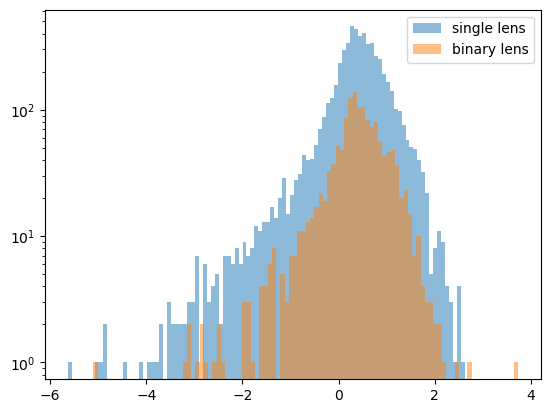

In [31]:
select_feat = x1
# bins = np.linspace(-25, 25, 100)
plt.hist(select_feat[label==0], bins = 100, alpha=0.5 , label = 'single lens')
plt.hist(select_feat[label==1], bins = 100, alpha=0.5, label = 'binary lens')


plt.yscale('log')
# plt.xlim(-10,10)
plt.legend()

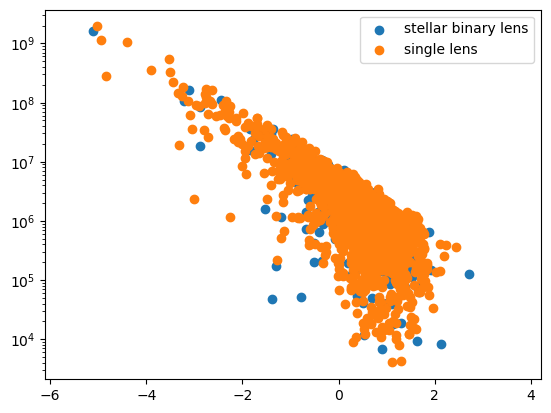

In [35]:
plt.scatter(x1[label==1], x2[label==1]*1e7, label='stellar binary lens')
plt.scatter(x1[label==0], x2[label==0]*1e7, label='single lens')
# plt.ylim(0.01,1)
plt.yscale('log')
plt.legend()

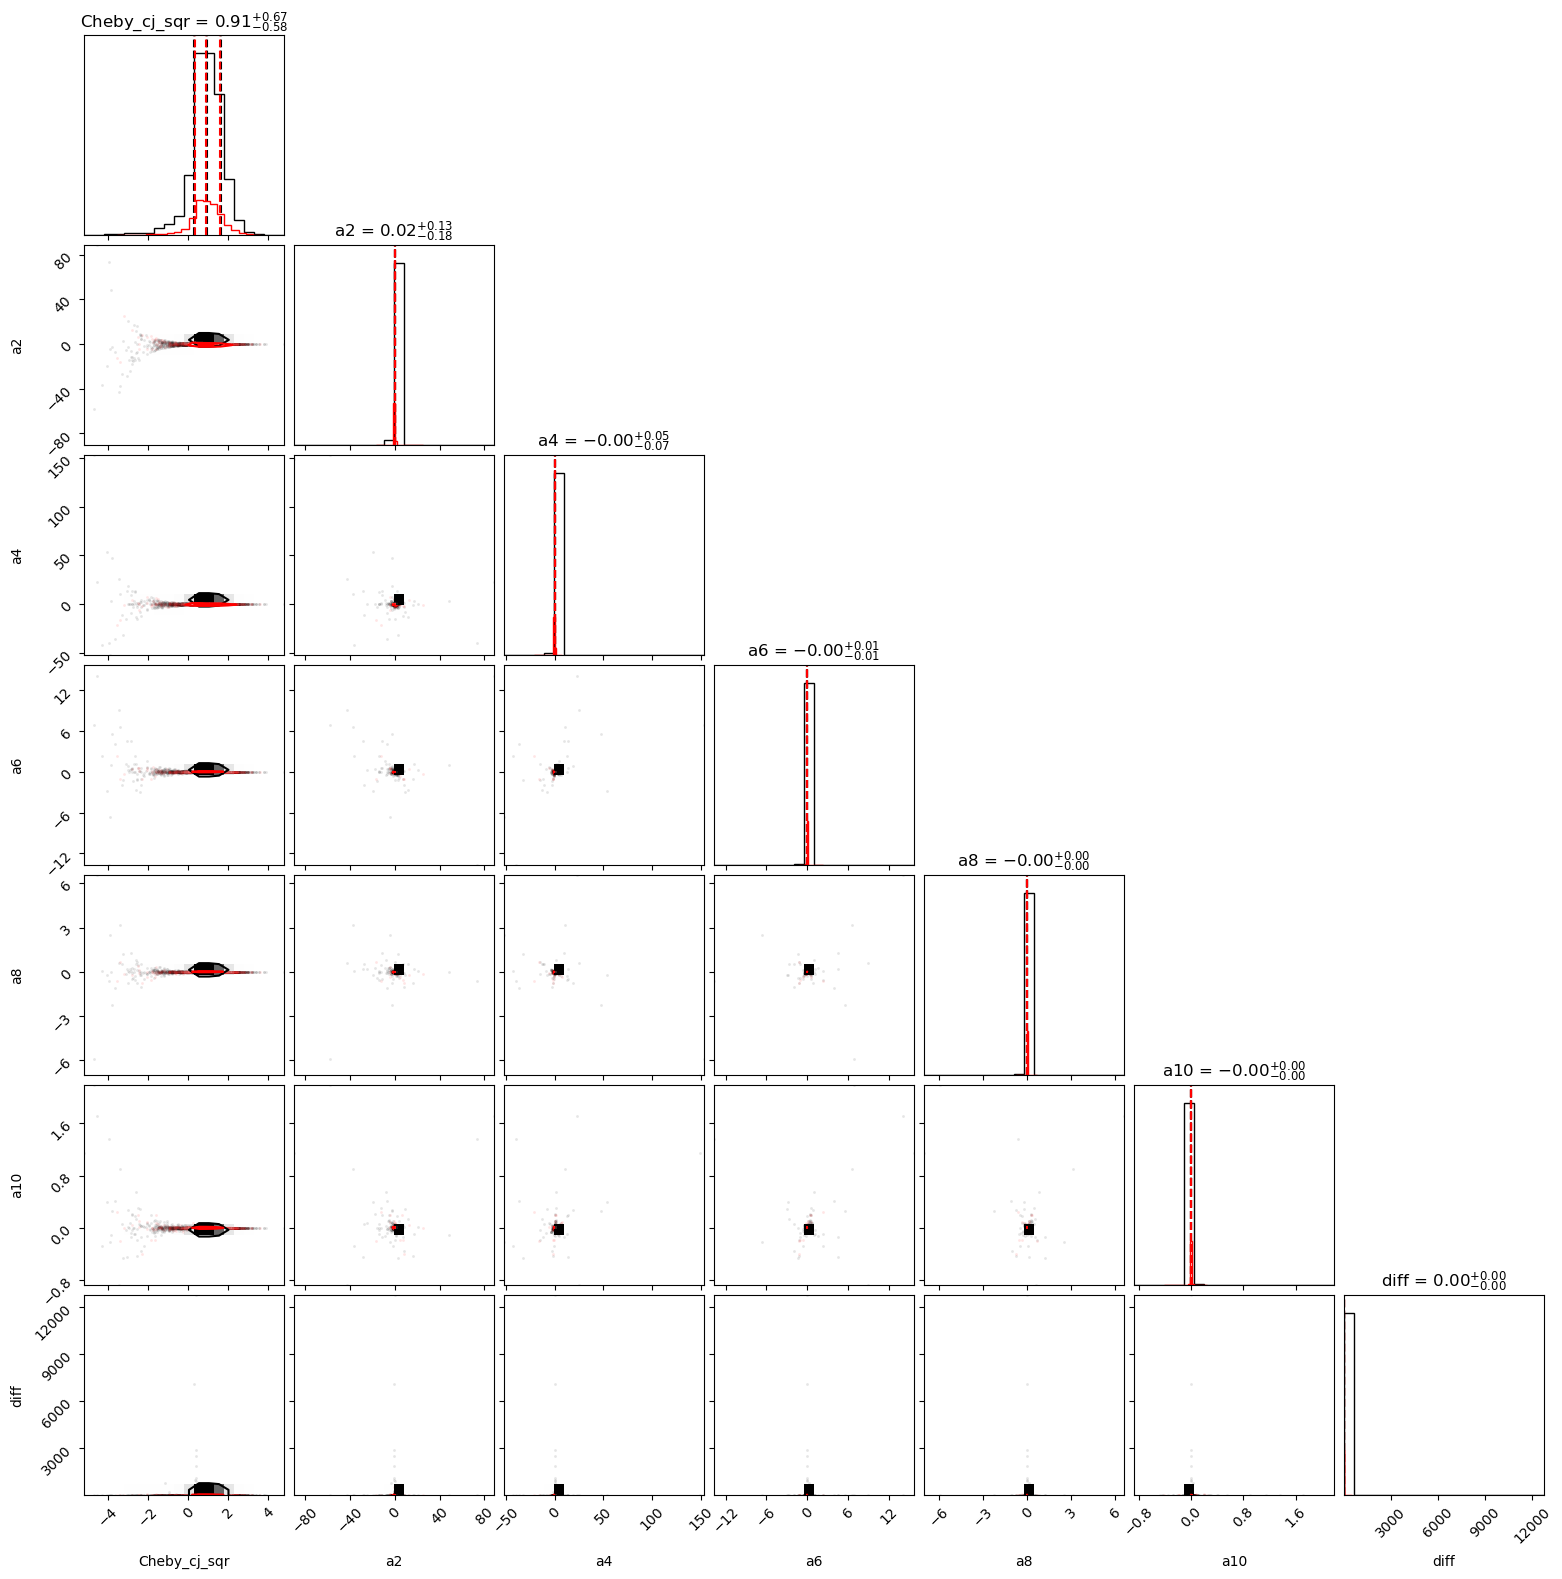

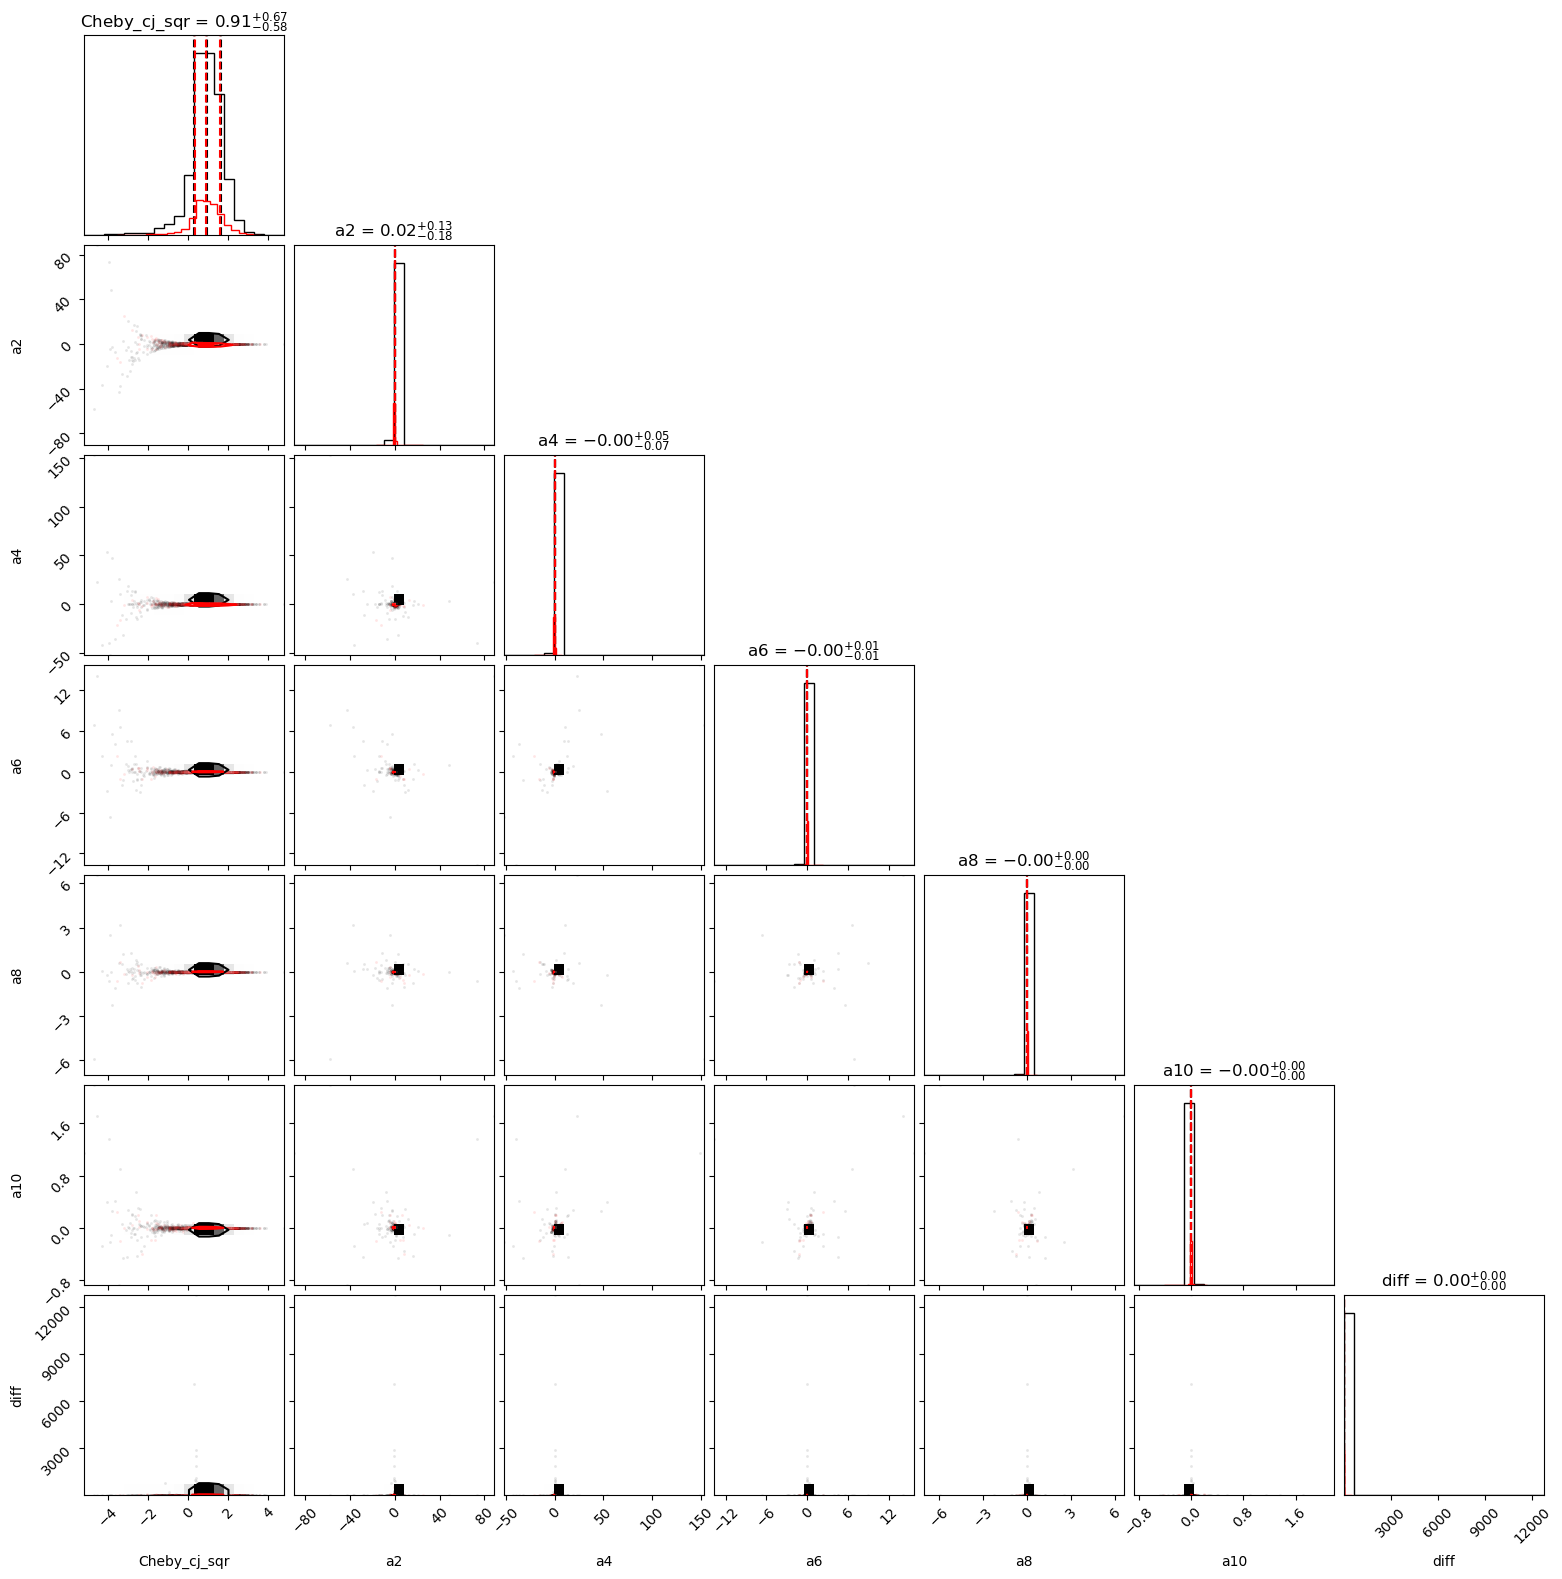

In [30]:
import corner
errors = np.stack((x1, x2, x3, x4, x5, x6, x7), axis=1)
labels_ = ['Cheby_cj_sqr','a2','a4', 'a6', 'a8', 'a10', 'diff']
scaler = MinMaxScaler()
plot_data = scaler.fit_transform(errors)
figure = corner.corner(errors[label==0], 
                       labels=labels_,
                       quantiles=(0.16,0.5,  0.84),
                      show_titles=True,
                       color='black',
                        title_kwargs={"fontsize": 12})
corner.corner(errors[label==1], 
                       labels=labels_,
                       quantiles=(0.16,0.5,  0.84),
                      show_titles=True,
                       color='red',
                        fig=figure,
                        title_kwargs={"fontsize": 12})

In [35]:
len(all_params[:, -1, 1][label==0])

6377

In [36]:
len(all_params[:, -1, 1][label==1])

1574